# Model Fitting II

### Addressing Endogeneity

To address the issue of endogeneity we need to find instruments for hours of studying that have the following characteristics:

* $\mathrm{Cov}[z, studying] \ne 0 \ \quad$ (hours of studying covaries with $z$)
* $\mathrm{Cov}[z, \varepsilon] = 0 \ \ \ \quad\quad\quad$ ($z$ is exogenous)

Looking at the variables in our dataset, `school_GP`, `goout`, and `male` are valid instruments we can use for our analysis. In addition, based off our two way frequency table (see Data Exploration) we found that 49 people stated they had picked the school because of its proximity to home and that they had a commute time greater than 15 minutes. This subset eliminates people that may have picked the school for reasons that may directly affect how much their test scores (e.g. Picking a school because of "Courses" might correlate with test scores) and only affects test scores indirectly through study time. Thus we can use this combination of variables as an artificial instrument.

Below we will use our instruments in a 2 stage least squares regression.


In [1]:
# Loading the libraries we will use and setting global options

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import quadratic2SLS as q2sls

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import self-made functions
from p3functions import *

In [10]:
#Load in cleaned data and resutls from our naive OLS fit
student_both = pd.read_pickle('data/student_both_v3.pkl')
student_por  = pd.read_pickle('data/student_por_v3.pkl')
student_mat  = pd.read_pickle('data/student_mat_v3.pkl')

In [ ]:
# Variable Name Selection

# names for individual course datasets
exog_names = ['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
               #'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               'health_1', 'health_2', 'health_4', 'health_5']

# names for both course datasets (includes `course_math` indicator)
exog_names2 = ['school_GP', 'course_math', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
               'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
               'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
               'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
               'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
               'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
               'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
               #'reason_home', 'reason_course', 'reason_reputation',
               #'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
               'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
               'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
               'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
               'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
               'health_1', 'health_2', 'health_4', 'health_5']

### 2SLS Model Fitting

*Note:* The write up explains why 2SLS might not be the best method for identifying $\beta$ in this setting. We include 2SLS results to compare the non standard Q2SLS results to a more familiar model.

In [8]:
# Running the 2SLS model

# ----- Both Courses -----
# Dependent variable
Y = student_both.G3_perc

# Exogenous variables
X_exog = student_both[exog_names2]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_both[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z = student_both[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_both = IV2SLS(Y, X_exog, X_endog, Z)
results2SLS_both = model2SLS_both.fit()


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z2 = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_por = IV2SLS(Y2, X_exog2, X_endog2, Z2)
results2SLS_por = model2SLS_por.fit()


# ----- Mathematics Course -----
# Dependent variable
Y3 = student_mat.G3_perc

# Exogenous variables
X_exog3 = student_mat[exog_names]
X_exog3 = sm.add_constant(X_exog3)

# Endogenous variable
X_endog3 = student_mat[['studytime_continuous', 'studytime_continuous_sq']]

# Instruments
student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z3 = student_mat[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model2SLS_mat = IV2SLS(Y3, X_exog3, X_endog3, Z3)
results2SLS_mat = model2SLS_mat.fit()

In [9]:
results2SLS_both.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -1.2053
Estimator:                    IV-2SLS   Adj. R-squared:                -1.3328
No. Observations:                1044   F-statistic:                    187.20
Date:                Tue, May 15 2018   P-value (F-stat)                0.0000
Time:                        13:21:57   Distribution:                 chi2(57)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       1.0221     0.3064     3.3361     0.0008      0.4216      1.6226
school_GP                   0.0153     0.0333     0.4591     0.6462     -0.0500      0.0805
course_math                -0.1026     0.0229    -4.4784     0.0000     -0.1475     -0.0577
male                        0.0869     0.0406     2.1377     0.0325      0.0072      0.1665
age                        -0.0277     0.0148    -1.8697     0.0615     -0.0568      0.0013
urban                       0.0106     0.0281     0.3784     0.7051     -0.0445      0.0658
fam_small                   0.0536     0.0251     2.1312     0.0331      0.0043      0.1029
fam_split                  -0.0434     0.0371    -1.1707     0.2417     -0.1162      0.0293
mother                     -0.0382     0.0480    -0.7945     0.4269     -0.1323      0.0560
father                      0.0148     0.0493     0.2999     0.7642     -0.0818      0.1113
failures                   -0.0741     0.0201    -3.6932     0.0002     -0.1134     -0.0348
school_sup                 -0.0718     0.0303    -2.3698     0.0178     -0.1312     -0.0124
famsup                     -0.0287     0.0218    -1.3149     0.1885     -0.0714      0.0141
paid                       -0.0054     0.0290    -0.1849     0.8533     -0.0623      0.0515
activities                 -0.0227     0.0239    -0.9517     0.3413     -0.0695      0.0241
nursery                    -0.0179     0.0247    -0.7226     0.4700     -0.0664      0.0306
higher                     -0.0497     0.0676    -0.7353     0.4622     -0.1822      0.0828
internet                    0.0150     0.0263     0.5693     0.5691     -0.0366      0.0666
romantic                   -0.1054     0.0447    -2.3594     0.0183     -0.1929     -0.0178
absences                    0.0033     0.0019     1.6999     0.0891     -0.0005      0.0071
Mjob_teach                 -0.0453     0.0513    -0.8833     0.3771     -0.1458      0.0552
Mjob_health                 0.0391     0.0578     0.6759     0.4991     -0.0742      0.1523
Mjob_civil                  0.0366     0.0331     1.1074     0.2681     -0.0282      0.1014
Mjob_other                  0.0035     0.0264     0.1313     0.8955     -0.0482      0.0551
Fjob_teach                  0.1146     0.0660     1.7362     0.0825     -0.0148      0.2439
Fjob_health                 0.0603     0.1158     0.5210     0.6023     -0.1666      0.2872
Fjob_civil                  0.0357     0.0504     0.7075     0.4793     -0.0632      0.1345
Fjob_other                  0.0622     0.0482     1.2916     0.1965     -0.0322      0.1566
Medu_primary               -0.1078     0.0781    -1.3810     0.1673     -0.2608      0.0452
Medu_5_9                   -0.0757     0.0875    -0.8650     0.3871     -0.2472      0.0958
Medu_secondary             -0.0670     0.0970    -0.6905     0.4899     -0.2570      0.1231
Medu_higher    

In [6]:
results2SLS_por.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -1.3463
Estimator:                    IV-2SLS   Adj. R-squared:                -1.5682
No. Observations:                 649   F-statistic:                    133.74
Date:                Tue, May 15 2018   P-value (F-stat)                0.0000
Time:                        13:20:04   Distribution:                 chi2(56)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       0.8417     0.3726     2.2590     0.0239      0.1114      1.5720
school_GP                   0.0277     0.0346     0.7996     0.4239     -0.0401      0.0954
male                        0.0315     0.0444     0.7099     0.4778     -0.0556      0.1187
age                        -0.0204     0.0191    -1.0709     0.2842     -0.0578      0.0169
urban                       0.0129     0.0267     0.4853     0.6274     -0.0393      0.0652
fam_small                   0.0362     0.0257     1.4082     0.1591     -0.0142      0.0865
fam_split                  -0.0489     0.0414    -1.1810     0.2376     -0.1301      0.0323
mother                     -0.0501     0.0595    -0.8415     0.4000     -0.1667      0.0665
father                     -0.0111     0.0558    -0.1984     0.8427     -0.1204      0.0983
failures                   -0.0605     0.0219    -2.7676     0.0056     -0.1034     -0.0177
school_sup                 -0.0890     0.0388    -2.2938     0.0218     -0.1651     -0.0130
famsup                     -0.0183     0.0245    -0.7498     0.4534     -0.0663      0.0296
paid                       -0.0054     0.0466    -0.1162     0.9075     -0.0967      0.0859
activities              -2.852e-05     0.0258    -0.0011     0.9991     -0.0506      0.0506
nursery                    -0.0185     0.0263    -0.7041     0.4814     -0.0701      0.0330
higher                     -0.0305     0.0778    -0.3916     0.6954     -0.1830      0.1220
internet                    0.0147     0.0267     0.5507     0.5819     -0.0376      0.0670
romantic                   -0.0779     0.0453    -1.7207     0.0853     -0.1666      0.0108
absences                    0.0027     0.0036     0.7671     0.4430     -0.0042      0.0097
Mjob_teach                 -0.0137     0.0542    -0.2533     0.8000     -0.1200      0.0925
Mjob_health                 0.0383     0.0588     0.6511     0.5150     -0.0769      0.1535
Mjob_civil                  0.0261     0.0349     0.7472     0.4549     -0.0423      0.0945
Mjob_other                  0.0029     0.0269     0.1083     0.9138     -0.0498      0.0557
Fjob_teach                  0.0929     0.0735     1.2641     0.2062     -0.0511      0.2369
Fjob_health                 0.0271     0.1176     0.2307     0.8175     -0.2034      0.2577
Fjob_civil                  0.0082     0.0456     0.1800     0.8571     -0.0811      0.0975
Fjob_other                  0.0488     0.0483     1.0104     0.3123     -0.0459      0.1436
Medu_primary               -0.0393     0.0764    -0.5147     0.6068     -0.1890      0.1104
Medu_5_9                   -0.0176     0.0827    -0.2134     0.8310     -0.1797      0.1445
Medu_secondary             -0.0101     0.0921    -0.1102     0.9123     -0.1906      0.1703
Medu_higher                 0.0142     0.1044     0.1361     0.8917     -0.1904      0.2188
Fedu_primary   

In [7]:
results2SLS_mat.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                G3_perc   R-squared:                     -2.2194
Estimator:                    IV-2SLS   Adj. R-squared:                -2.7528
No. Observations:                 395   F-statistic:                    62.928
Date:                Tue, May 15 2018   P-value (F-stat)                0.2445
Time:                        13:20:04   Distribution:                 chi2(56)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
const                       1.3157     0.6473     2.0327     0.0421      0.0471      2.5843
school_GP                   0.0493     0.1154     0.4272     0.6693     -0.1769      0.2755
male                        0.1674     0.0938     1.7846     0.0743     -0.0164      0.3512
age                        -0.0402     0.0285    -1.4079     0.1592     -0.0961      0.0158
urban                      -0.0476     0.0933    -0.5097     0.6102     -0.2304      0.1353
fam_small                   0.1137     0.0761     1.4951     0.1349     -0.0354      0.2629
fam_split                  -0.0683     0.0919    -0.7428     0.4576     -0.2483      0.1118
mother                     -0.0555     0.0927    -0.5990     0.5491     -0.2371      0.1261
father                      0.0554     0.1293     0.4285     0.6683     -0.1981      0.3089
failures                   -0.1048     0.0403    -2.6012     0.0093     -0.1838     -0.0258
school_sup                 -0.0460     0.0653    -0.7044     0.4812     -0.1740      0.0820
famsup                     -0.0340     0.0481    -0.7062     0.4801     -0.1282      0.0603
paid                        0.0047     0.0527     0.0883     0.9297     -0.0986      0.1079
activities                 -0.0605     0.0580    -1.0437     0.2966     -0.1741      0.0531
nursery                     0.0003     0.0607     0.0045     0.9964     -0.1187      0.1192
higher                     -0.0552     0.1475    -0.3741     0.7083     -0.3442      0.2338
internet                    0.0256     0.0720     0.3555     0.7222     -0.1155      0.1667
romantic                   -0.1885     0.1151    -1.6367     0.1017     -0.4141      0.0372
absences                    0.0031     0.0034     0.9015     0.3673     -0.0036      0.0097
Mjob_teach                 -0.1533     0.1335    -1.1483     0.2509     -0.4150      0.1084
Mjob_health                -0.0107     0.1407    -0.0764     0.9391     -0.2864      0.2649
Mjob_civil                  0.0251     0.0899     0.2791     0.7802     -0.1512      0.2014
Mjob_other                  0.0010     0.0731     0.0134     0.9893     -0.1424      0.1443
Fjob_teach                  0.1581     0.1469     1.0761     0.2819     -0.1298      0.4459
Fjob_health                 0.2289     0.2644     0.8656     0.3867     -0.2894      0.7472
Fjob_civil                  0.1516     0.1623     0.9342     0.3502     -0.1664      0.4696
Fjob_other                  0.1099     0.1331     0.8257     0.4090     -0.1509      0.3707
Medu_primary               -0.2461     0.2142    -1.1489     0.2506     -0.6659      0.1737
Medu_5_9                   -0.1429     0.2306    -0.6194     0.5356     -0.5949      0.3092
Medu_secondary             -0.1105     0.2517    -0.4391     0.6606     -0.6039      0.3828
Medu_higher                 0.0139     0.2886     0.0481     0.9616     -0.5518      0.5795
Fedu_primary   

In [54]:
#### JUST CHECKING VARIOUS PARAMETERS, DELETE THIS CHUNK LATER
results2SLS_both.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 2.7210
P-value: 0.4367
Distributed: chi2(3)
WaldTestStatistic, id: 0x1c2705ea58

### Q2SLS Model Fitting

# NEED TO FIGURE OUT BOOTSTRAPPING FOR ERRORS
--> and change n_iter to something reasonable, now its low for runtime

In [11]:
# Running the Q2SLS model

# ----- Both Courses -----
# Dependent variable
Y1 = student_both.G3_perc

# Exogenous variables
X_exog1 = student_both[exog_names2]
X_exog1 = sm.add_constant(X_exog1)

# Endogenous variable
X_endog1 = student_both.studytime_continuous

# Instruments
student_both['artificial_instrument'] = ((student_both.reason == 'home') & (student_both.traveltime > 1)).astype(int)
Z1 = student_both[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_both = q2sls.Quadratic2SLS(Y1, X_exog1, X_endog1, Z1)
resultsQ2SLS_both = modelQ2SLS_both.fit(cov_type='Bootstrap', n_iter=100)


# ----- Portuguese Language Course -----
# Dependent variable
Y2 = student_por.G3_perc

# Exogenous variables
X_exog2 = student_por[exog_names]
X_exog2 = sm.add_constant(X_exog2)

# Endogenous variable
X_endog2 = student_por.studytime_continuous

# Instruments
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z2 = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_por = q2sls.Quadratic2SLS(Y2, X_exog2, X_endog2, Z2)
resultsQ2SLS_por = modelQ2SLS_por.fit(cov_type='Bootstrap', n_iter=100)


# ----- Mathematics Course -----
# Dependent variable
Y = student_mat.G3_perc

# Exogenous variables
X_exog = student_mat[exog_names]
X_exog = sm.add_constant(X_exog)

# Endogenous variable
X_endog = student_mat.studytime_continuous

# Instruments
student_mat['artificial_instrument'] = ((student_mat.reason == 'home') & (student_mat.traveltime > 1)).astype(int)
Z = student_mat[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

modelQ2SLS_mat = q2sls.Quadratic2SLS(Y, X_exog, X_endog, Z)
resultsQ2SLS_mat = modelQ2SLS_mat.fit(cov_type='Bootstrap', n_iter=100)

100%|██████████| 100/100 [00:01<00:00, 61.31it/s]


In [12]:
# Results - Both Courses
coeff_estms_Q2SLS_both = pd.DataFrame([resultsQ2SLS_both.beta_hat_boots.mean(axis=0), resultsQ2SLS_both.result2.params]).transpose()
coeff_estms_Q2SLS_both.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_Q2SLS_both.head()

,Bootstrapped,Full_Sample
const,0.623269,0.601114
endog_hat,0.029848,0.040524
endog_sq_hat,-0.000207,-0.000262
school_GP,0.022148,0.011719
course_math,-0.096805,-0.097838


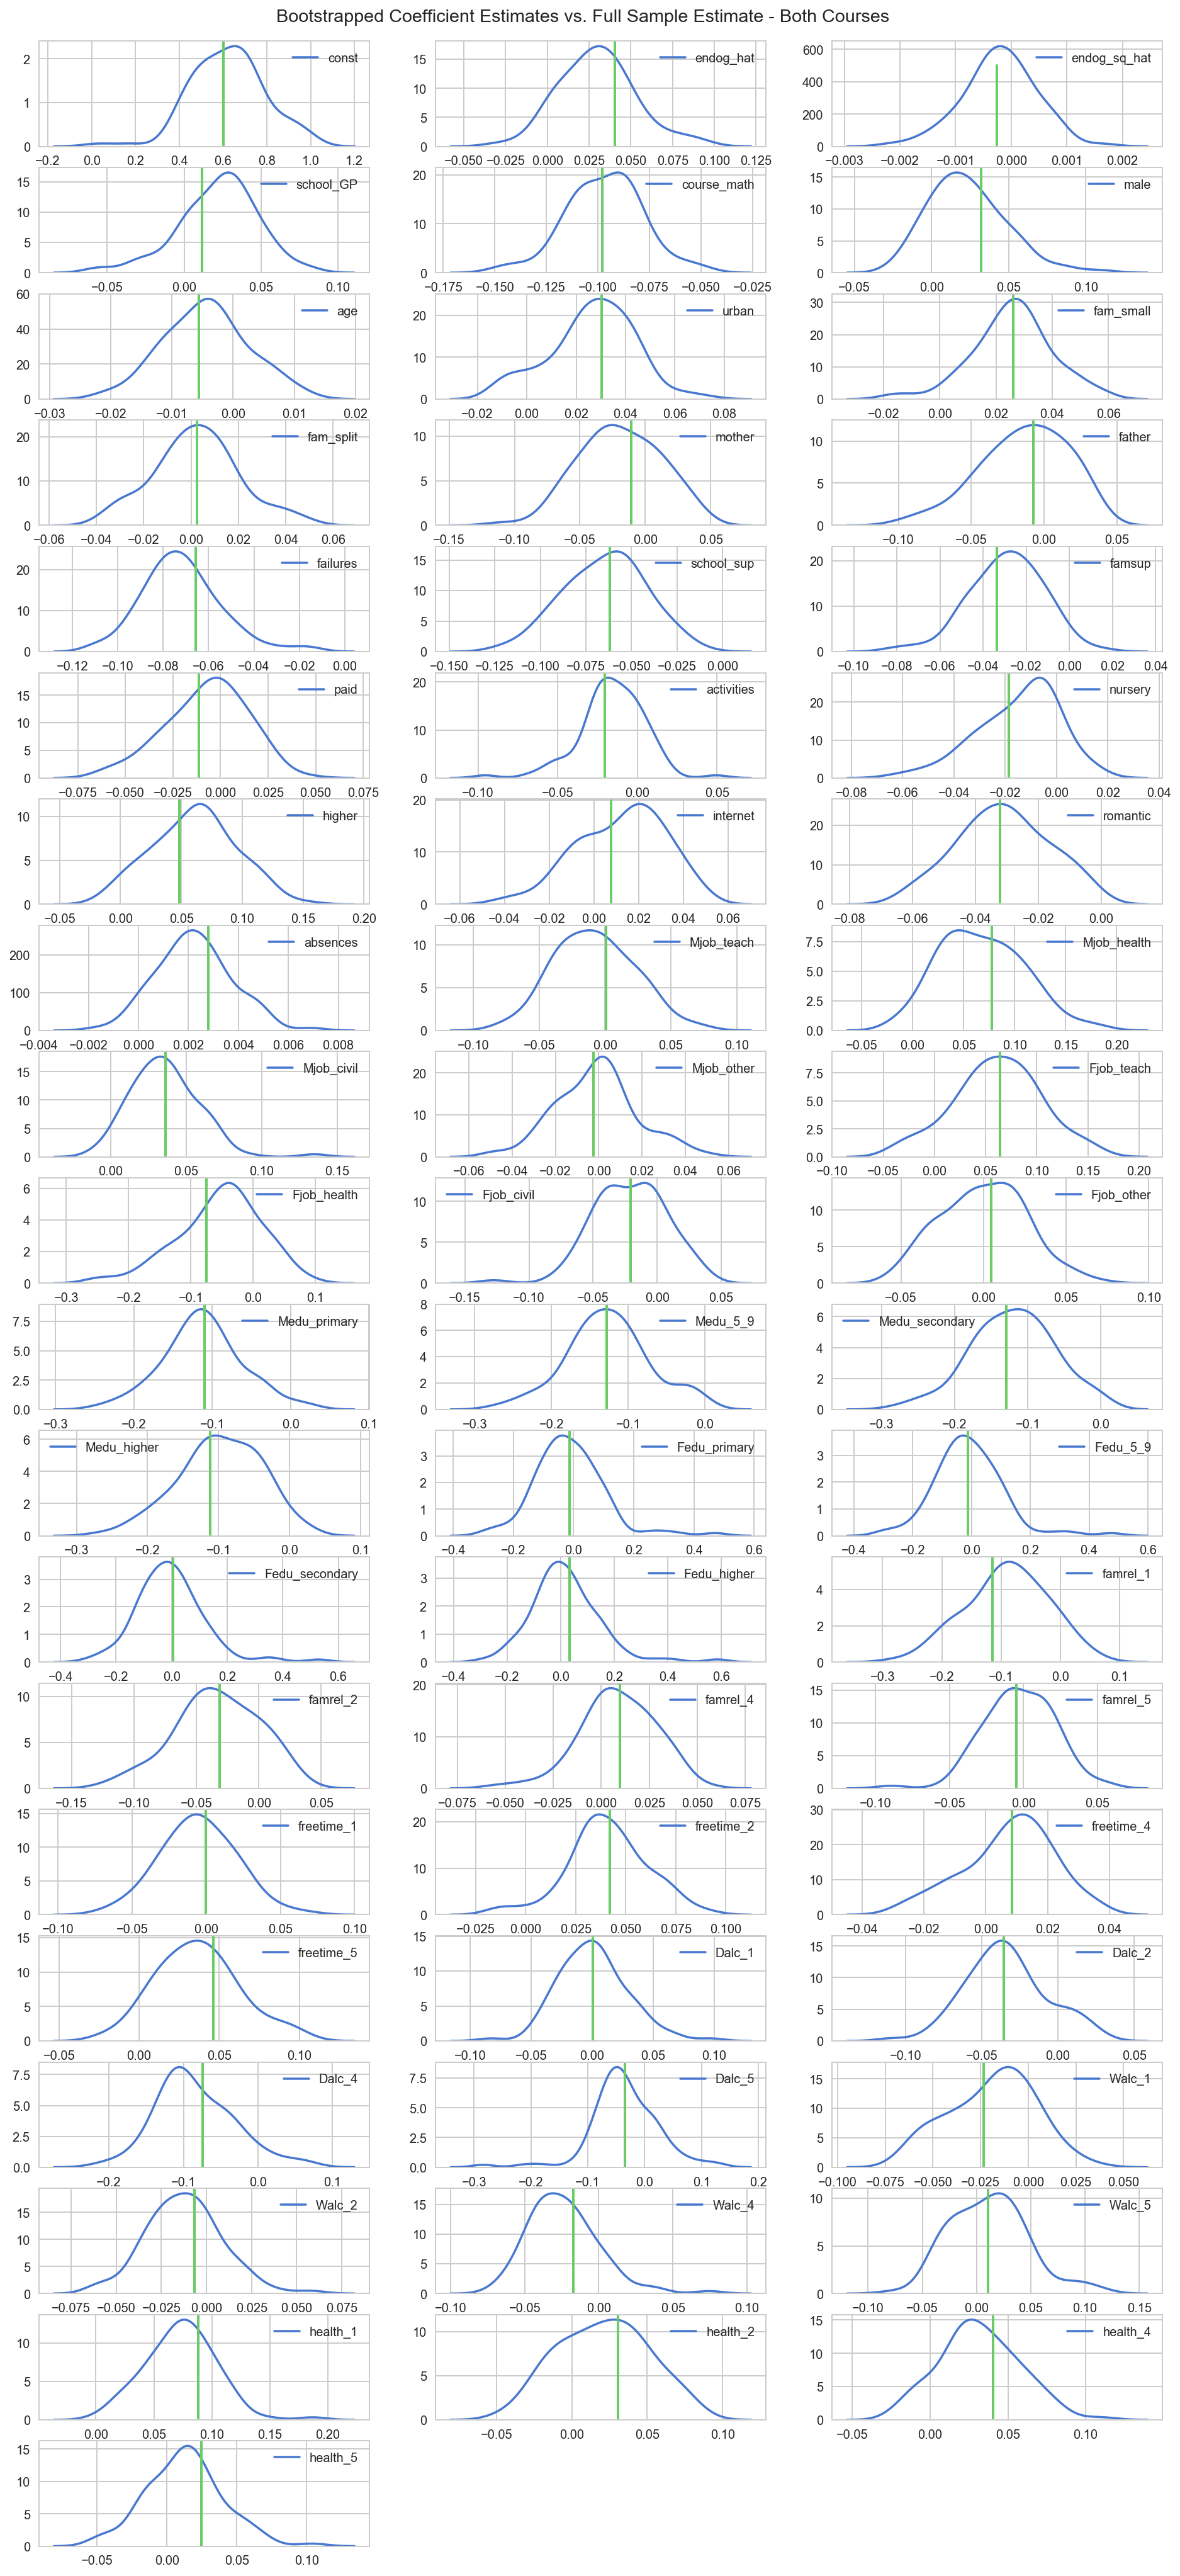

In [15]:
# Creating the plots - Both Courses
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs. Full Sample Estimate - Both Courses')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_both.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_both.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_both.result2.params[column_index], resultsQ2SLS_both.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)

In [16]:
# Results - Portuguese Language Course
coeff_estms_Q2SLS_por = pd.DataFrame([resultsQ2SLS_por.beta_hat_boots.mean(axis=0), resultsQ2SLS_por.result2.params]).transpose()
coeff_estms_Q2SLS_por.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_Q2SLS_por.head()

,Bootstrapped,Full_Sample
const,0.434497,0.406712
endog_hat,0.017373,0.033041
endog_sq_hat,-0.000061,-0.000466
school_GP,0.050793,0.045912
male,-0.026161,-0.017643


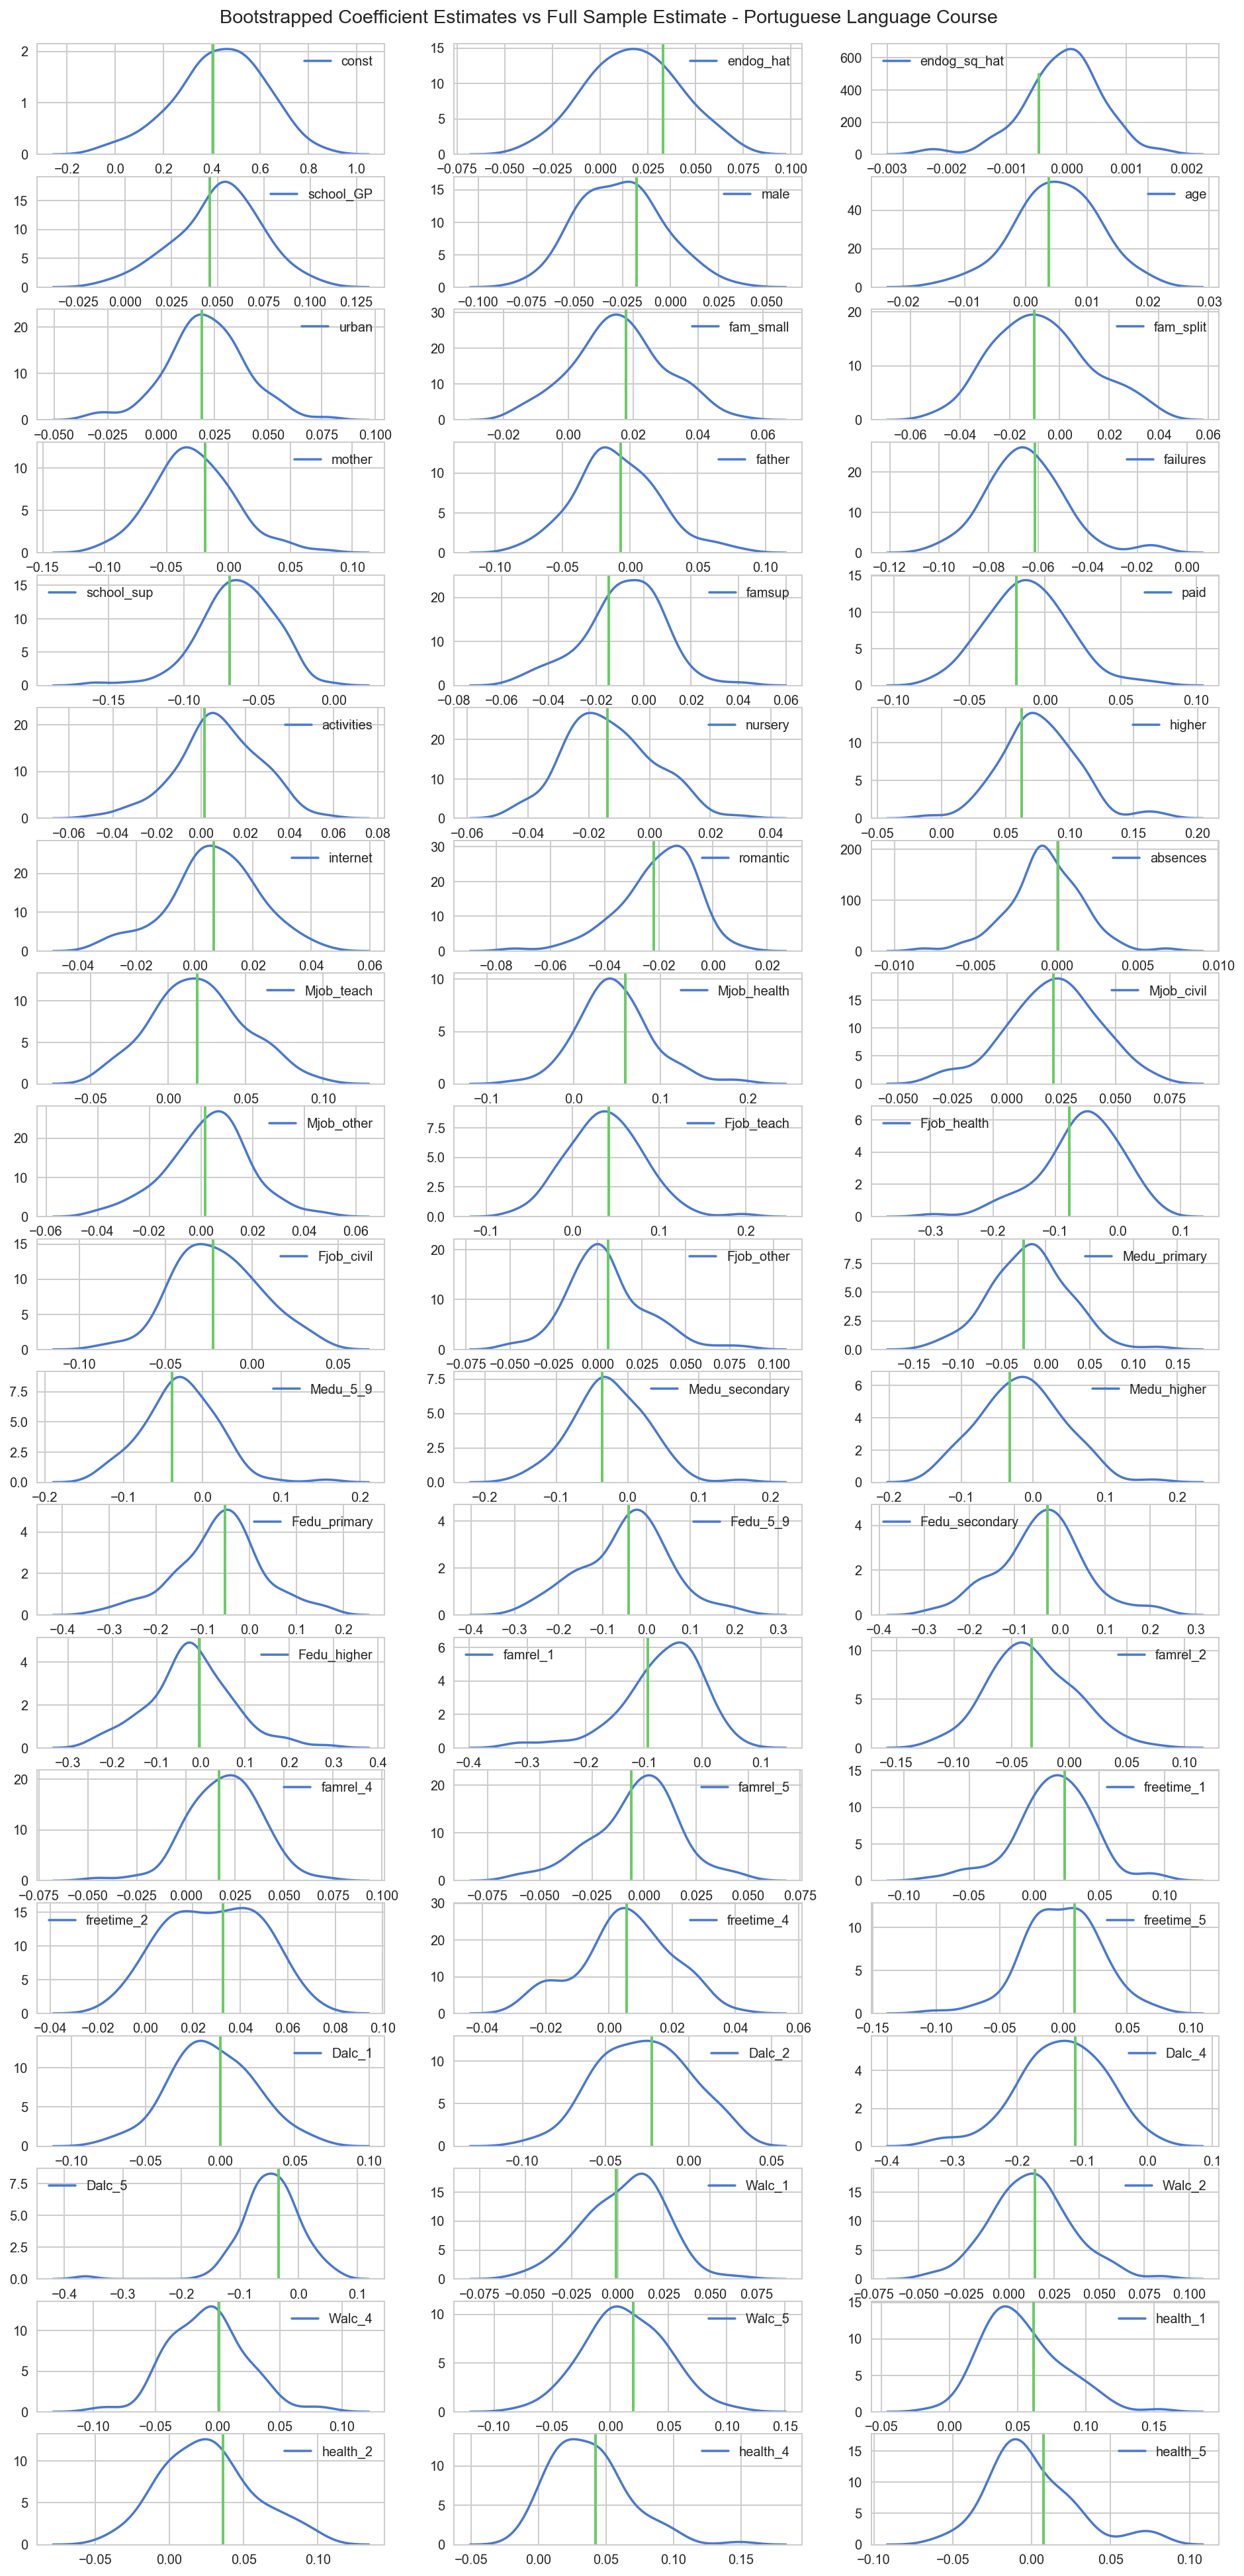

In [17]:
# Creating the plots - Portuguese Language Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Portuguese Language Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_por.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_por.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_por.result2.params[column_index], resultsQ2SLS_por.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)

In [18]:
# Results - Mathematics Course
coeff_estms_Q2SLS_mat = pd.DataFrame([resultsQ2SLS_mat.beta_hat_boots.mean(axis=0), resultsQ2SLS_mat.result2.params]).transpose()
coeff_estms_Q2SLS_mat.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_Q2SLS_mat.head()

,Bootstrapped,Full_Sample
const,1.107320,1.097460
endog_hat,0.019242,0.017096
endog_sq_hat,0.000127,0.000626
school_GP,-0.052109,-0.055536
male,0.083956,0.083955


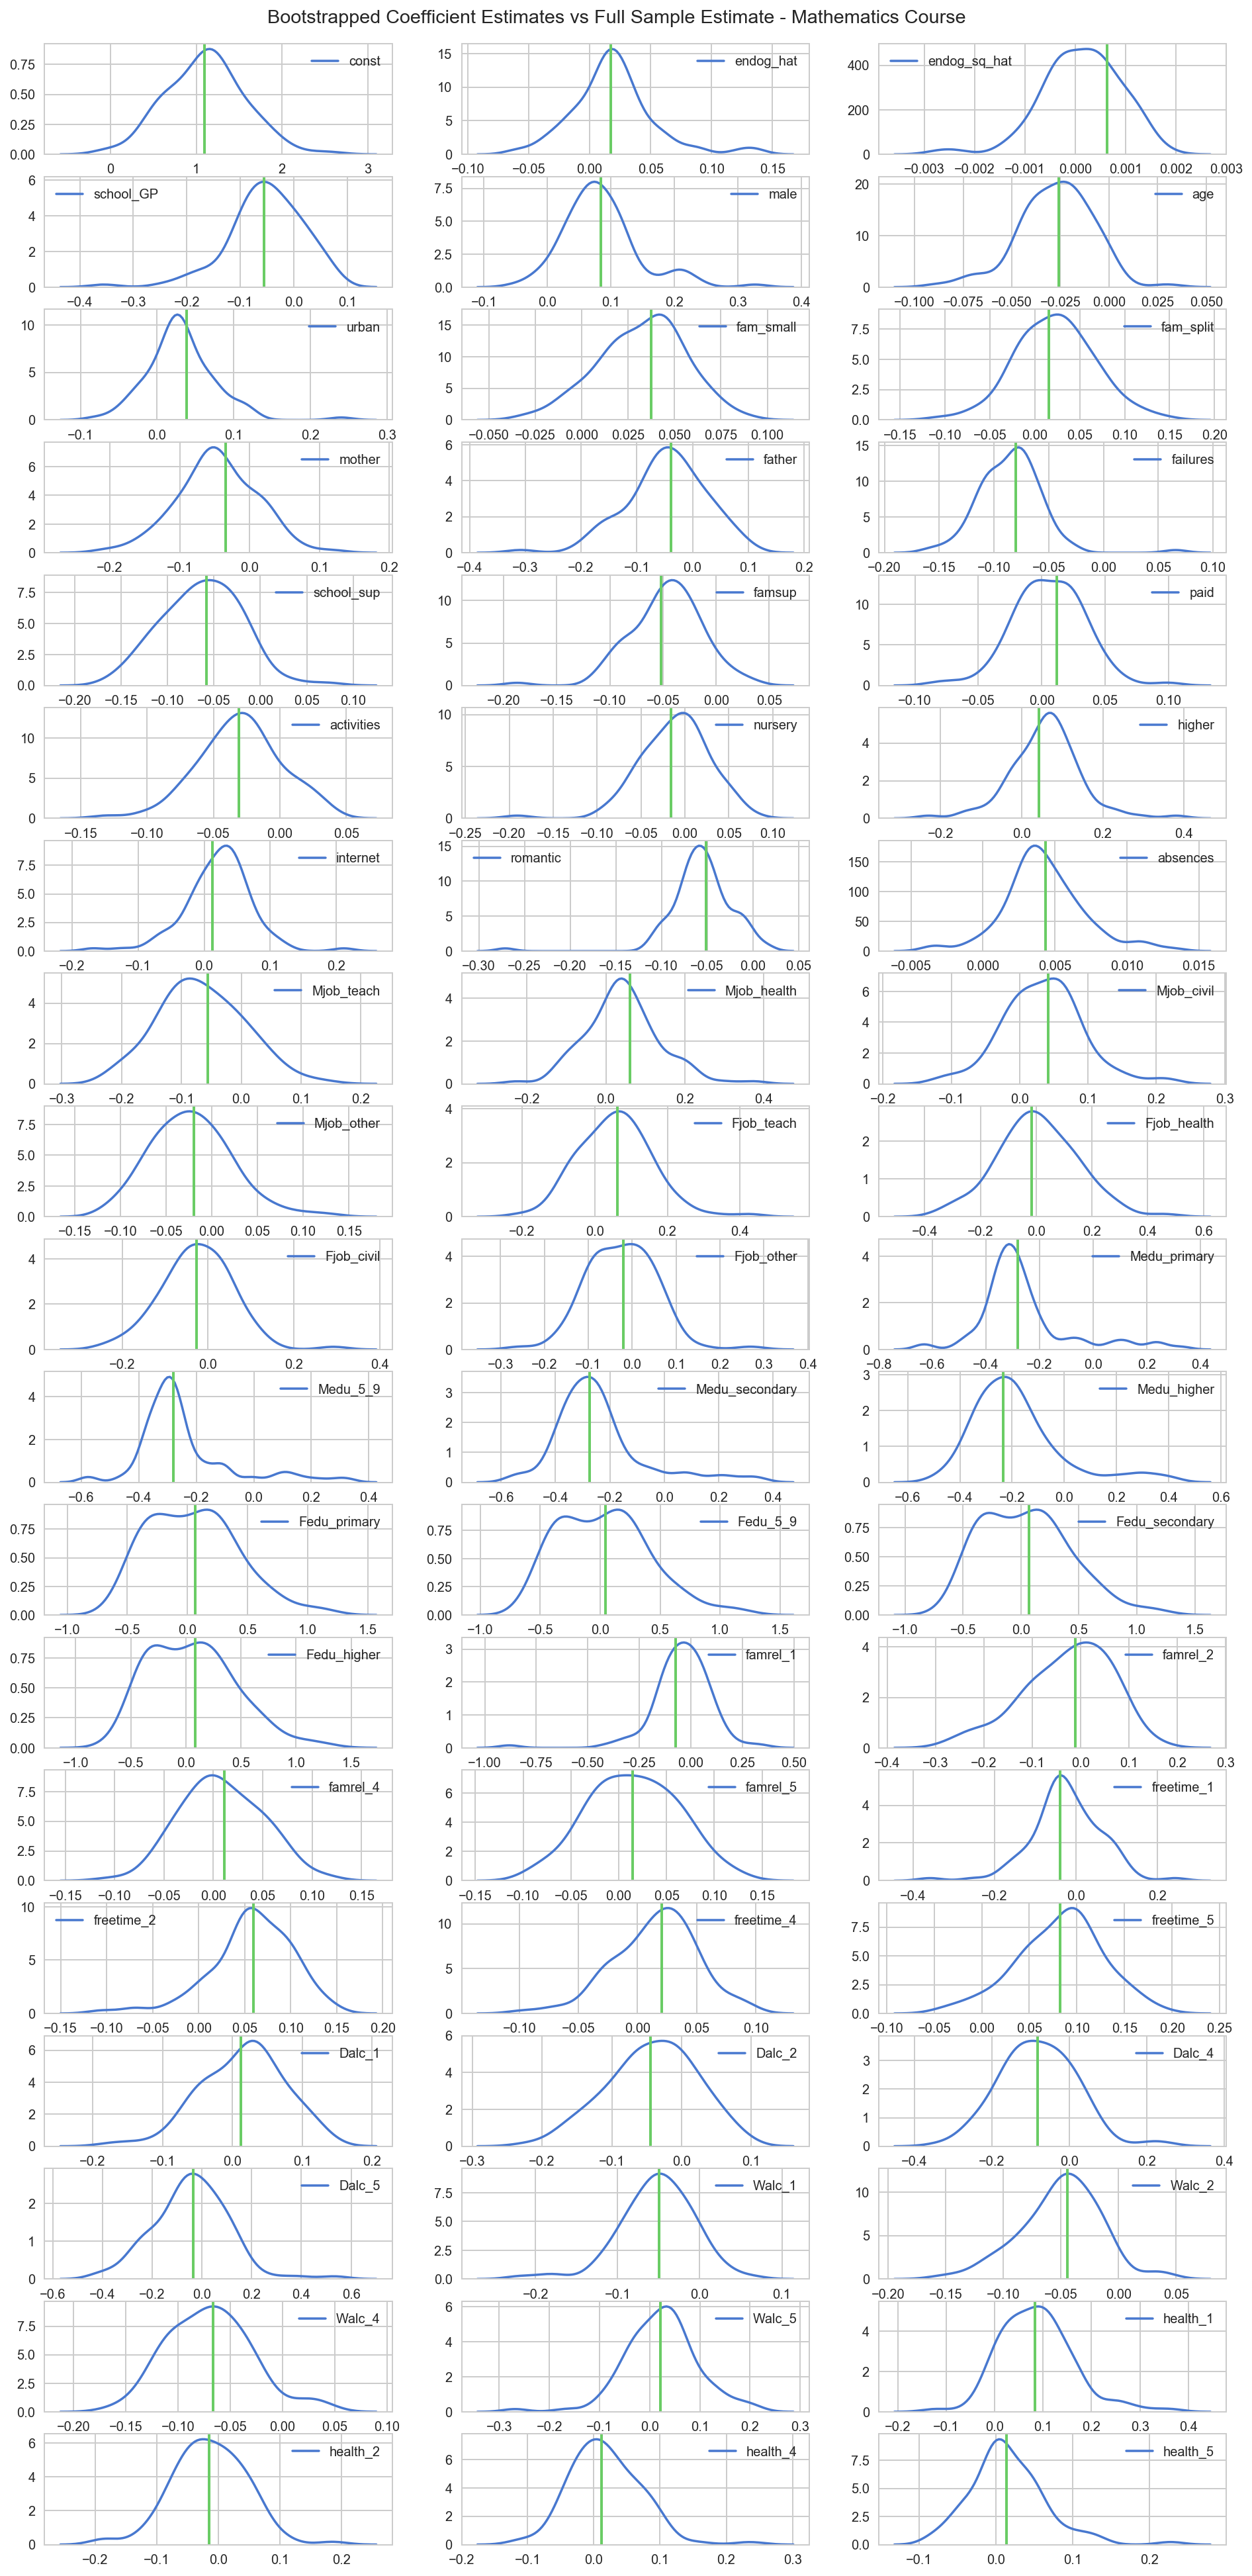

In [19]:
# Creating the plots - Mathematics Course
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates vs Full Sample Estimate - Mathematics Course')

sns.despine()
for column_index, column in enumerate(resultsQ2SLS_mat.X_hat.columns.values.tolist()):
    plt.subplot(22, 3, column_index + 1)
    sns.kdeplot(resultsQ2SLS_mat.beta_hat_boots[column])
    plt.plot([resultsQ2SLS_mat.result2.params[column_index], resultsQ2SLS_mat.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)

# BELOW HERE IS OLD

In [21]:
np.mean(naive_ols.pvalues)

In [ ]:
np.mean(results.pvalues)

Comparing the average p values of the 2 models, its evident that our average coefficient significance has fallen from OLS to 2SLS which we expected. Let's take a look at which coefficients have become more significant in the 2SLS model.

In [ ]:
naive_ols.pvalues - results.pvalues

It seems like all coefficients became less significant except daily alcohol consumption, father's education, internet, nursery, and romantic. 

In [ ]:
#saving 2 way SLS model to our results directory
import pickle
with open('results/2SLS.pkl','wb') as f:
    pickle.dump(results,f)